VectorLinearRegressionでwightが直交行列になるかをconditional numberを用いて観察する。

In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import TN_utils
reload(TN_utils)
plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

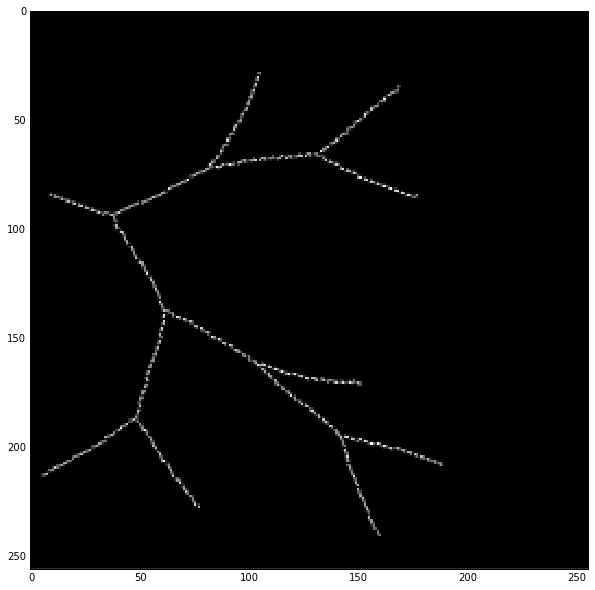

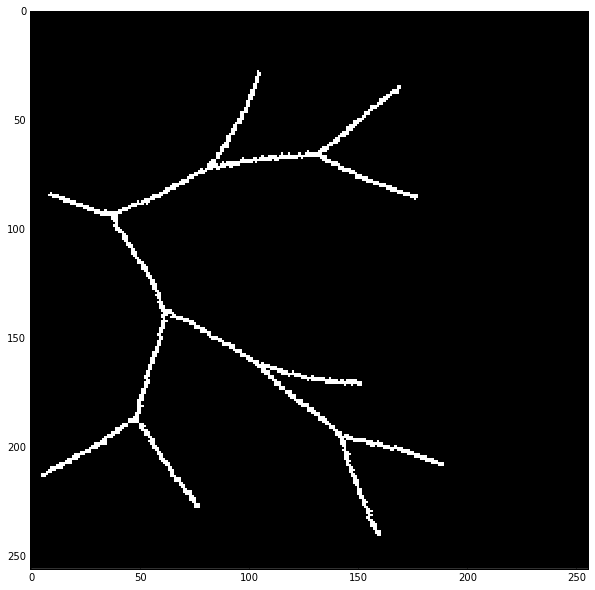

In [2]:
with gzip.open("../data/toytreerot_imgGT.npy.gz") as f:
    imGT_list = np.load(f)
imGT_list.shape
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))
for i in range(len(imGT_list)):
    index = np.linalg.norm(imGT_list[i], axis=1).nonzero()[0]
    imGT_list[i][index] = imGT_list[i][index] / np.linalg.norm(imGT_list[i], axis=1)[index][:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))

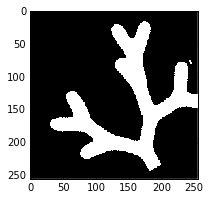

In [3]:
with gzip.open("../data/toytreerot_mask.npy.gz") as f:
    mask_list = np.load(f)
mask_list.shape
plt.figure(figsize=(3, 3))
plt.imshow(mask_list[20].reshape(256, 256))

In [4]:
featureImg_list = []
for i in range(1, 37):
    print i
    matlab_struct = sio.loadmat('../data/featureImgr' + str(i) + '.mat')
    featureImg = matlab_struct['f']

    # 複素数からベクトルへの変換
    featureImg_vec = np.zeros((featureImg.shape[0], 12, 2))
    featureImg_vec[:, :, 0] = np.real(featureImg[:, 12:24])
    featureImg_vec[:,:,1] = np.imag(featureImg[:, 12:24])
    featureImg_list.append(featureImg_vec)

print featureImg.dtype, featureImg_list[1].shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
complex128 (65536, 12, 2)


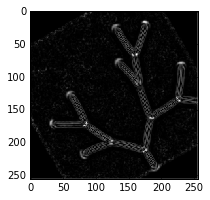

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(featureImg_list[20][:, 5], axis=1).reshape(256, 256))

In [6]:
m_featureImg_list = [featureImg_list[i][mask_list[i]] for i in range(36)]
m_imgGT_list = [imGT_list[i][mask_list[i]] for i in range(36)]

In [7]:
m_feature_t1 = m_featureImg_list[0]
m_GT_t1 = m_imgGT_list[0]
m_feature_t1.shape, m_GT_t1.shape

((13857, 12, 2), (13857, 2))

In [8]:
range(0, 36, 4)

[0, 4, 8, 12, 16, 20, 24, 28, 32]

In [9]:

m_feature_t12 = np.concatenate([m_featureImg_list[i] for i in range(0, 36, 4)], axis=0)
m_GT_t12 = np.concatenate([m_imgGT_list[i] for i in range(0, 36, 4)], axis=0)
print m_feature_t12.shape, m_GT_t12.shape

(124755, 12, 2) (124755, 2)


In [10]:
m_feature_t36 = np.concatenate([m_featureImg_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
m_GT_t36 = np.concatenate([m_imgGT_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
print m_feature_t36.shape, m_GT_t36.shape

(485423, 12, 2) (485423, 2)


In [11]:
m_feature_vec120 = m_featureImg_list[11]
m_GT_vec120 = m_imgGT_list[11]

In [12]:
activation_list = ["ReLU"]
n_tensors = 12
dim = 2
param_list = [0.01 * np.random.normal(size=(n_tensors*dim, dim)), np.zeros(dim)]

In [13]:
import theano_dnn
reload(theano_dnn)

Couldn't import dot_parser, loading of dot files will not be possible.


<module 'theano_dnn' from 'theano_dnn.pyc'>

In [14]:
vnn = theano_dnn.VnnClf(m_feature_t1, m_GT_t1,
                         m_feature_vec120, m_GT_vec120,
                         param_list, ["w1", "b1", "w2", "b2"], activation_list,
                       vector_activation_shape_list=[False])

In [15]:
vnn.initialize_params(param_list)

In [18]:
vnn.set_training(feature_list[1], GT_list[1]) 

In [19]:
batch_size = 100
l2 = 0.

n_batchs = vnn.n_pixels // batch_size
        
n_epochs = epoch_list[1]
interval = n_epochs // 30
training_MSE_array = np.zeros(n_epochs // interval)
test_MSE_array = np.zeros(n_epochs // interval)

In [20]:
cn_list_list = []
weighted_sum_list = []
lr = lr_list[1]
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        vnn.train(i_batch, lr, l2, batch_size)

    if i_epoch % interval == 0:
        MSE = vnn.training_error()
        training_MSE_array[i_epoch // interval] = MSE
        MSE = vnn.test_error()
        test_MSE_array[i_epoch // interval] = MSE

        w_list = vnn.get_w_list()
        cn_list = []
        for aw in w_list:
            cn_list.append(TN_utils.clcl_cn_inv(aw))
        cn_list_list.append(cn_list)
        w_norm_list = np.asarray([np.sum(w**2) for w in w_list])
        weighted_sum = np.sum(np.asarray(cn_list) * np.asarray(w_norm_list))
        n_weighted_sum = weighted_sum / np.sum(w_norm_list)
        weighted_sum_list.append(n_weighted_sum)

        print i_epoch, MSE

0 0.0446922597673
6 0.0361255728289
12 0.0354357670737
18 0.035288389416
24 0.0352288843416
30 0.0351958199213
36 0.0351749179335
42 0.0351598832957
48 0.0351488404895
54 0.0351406702215
60 0.0351336225789
66 0.0351279564362
72 0.0351230967773
78 0.0351190642244
84 0.0351163277758
90 0.0351136892829
96 0.0351101014024
102 0.0351073330323
108 0.0351052170876
114 0.0351029918488
120 0.0351007994274
126 0.0350992400673
132 0.0350985485439
138 0.0350986960054
144 0.035098367832
150 0.0350979807357
156 0.0350977488012
162 0.0350972453718
168 0.0350966454344
174 0.0350957857351


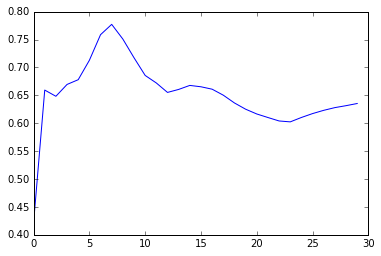

In [21]:
plt.plot(np.mean(cn_list_list, axis=1))

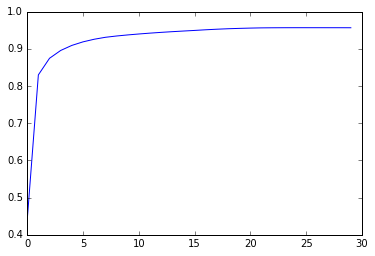

In [22]:
# まじか
plt.plot(weighted_sum_list)

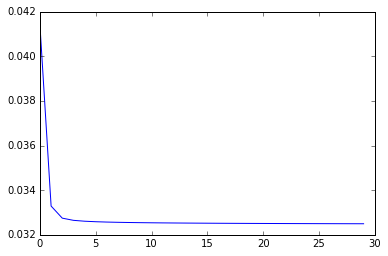

In [23]:
plt.plot(training_MSE_array)

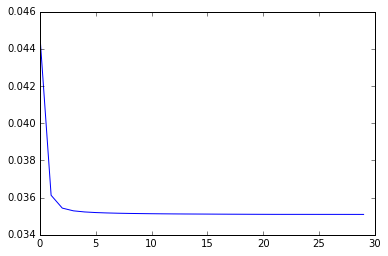

In [24]:
plt.plot(test_MSE_array)

In [25]:
import cond_num_dnn_ex
reload(cond_num_dnn_ex)

<module 'cond_num_dnn_ex' from 'cond_num_dnn_ex.pyc'>

In [26]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.0005, 0.0005, 0.0005]

In [27]:
feature_list[0].shape

(13857, 12, 2)

In [28]:
results = cond_num_dnn_ex.cond_num_dnn_ex(vnn, param_list, feature_list, GT_list, 
                                          lr_list, epoch_list, featureImg_list)

0 0.05381623875
144 0.0354854638547
288 0.0352651025306
432 0.0352470412563
576 0.0352533832915
720 0.0352655523338
864 0.0352803126255
1008 0.0352935987302
1152 0.0353057080675
1296 0.0353153203955
1440 0.0353247059501
1584 0.0353336191688
1728 0.0353420506786
1872 0.03535230369
2016 0.0353593169322
0 0.0446922597673
12 0.0354357670737
24 0.0352288843416
36 0.0351749179335
48 0.0351488404895
60 0.0351336225789
72 0.0351230967773
84 0.0351163277758
96 0.0351101014024
108 0.0351052170876
120 0.0351007994274
132 0.0350985485439
144 0.035098367832
156 0.0350977488012
168 0.0350966454344
0 0.0376970813541
4 0.0352210393715
8 0.035127560339
12 0.0350955394277
16 0.0350783977064
20 0.0350673563951
24 0.0350604579393
28 0.0350555752768
32 0.0350516576588
36 0.0350490489525
40 0.0350470848341
44 0.0350455506018
48 0.0350444126785
52 0.0350436745891
56 0.0350429025398


In [29]:
train_error_list, test_error_list, cn11236, wsc11236, gt1img360_list, gt1img120_list = results

In [30]:
namelist = ["train_error_list", "test_error_list", "cn11236", "wsc11236", "gt1img360_list", "gt1img120_list"]
for data, name in zip(results, namelist):
    with gzip.open("../results/CondNumVLRscalaract/"+name+".npy.gz", "w") as f:
        np.save(f, data)

In [31]:
with gzip.open("../results/CondNumVLRscalaract/gt1img360_list.npy.gz", "r") as f:
    gt1img360_list = np.load(f)
with gzip.open("../results/CondNumVLRscalaract/gt1img120_list.npy.gz", "r") as f:
    gt1img120_list = np.load(f)

In [148]:
with gzip.open("../results/CondNumVLRscalaract/cn11236.npy.gz", "r") as f:
    cn11236 = np.load(f)

In [32]:
gt1img120_list.shape

(3, 2, 256, 256)

In [33]:
sio.savemat('../results/CondNumVLRscalaract/v_train360_list.mat', {'v_train360_list': gt1img360_list})
sio.savemat('../results/CondNumVLRscalaract/v_train120_list.mat', {'v_train120_list': gt1img120_list})

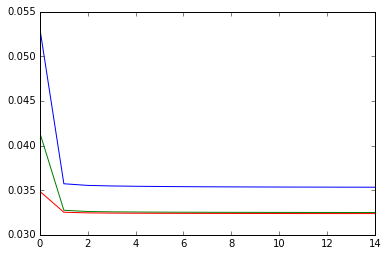

In [34]:
for i in range(3):    
    plt.plot(train_error_list[i])

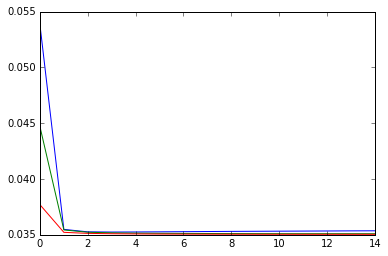

In [35]:
for i in range(3): 
    plt.plot(test_error_list[i])

In [36]:
seaborn.set_style("whitegrid")

NameError: name 'seaborn' is not defined

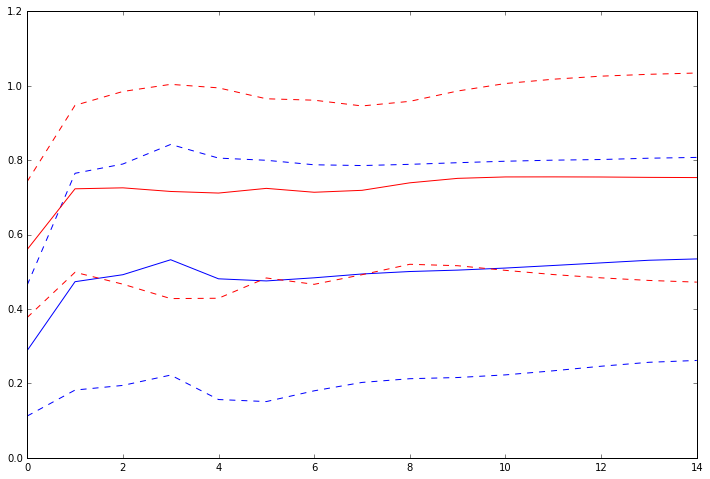

In [37]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
for i in [0, 2]:
    mean = np.mean(cn11236[i], axis=1)
    std = np.std(cn11236[i], axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i])
    plt.plot(x, mean - std, color_list[i]+"--")
    plt.plot(x, mean + std, color_list[i]+"--")

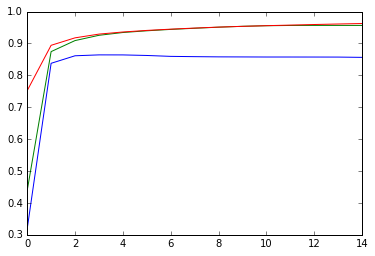

In [38]:
for i in range(3):
    plt.plot(wsc11236[i])

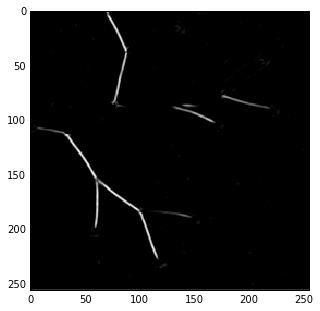

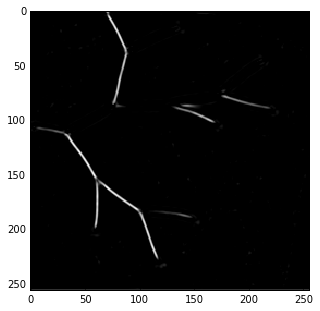

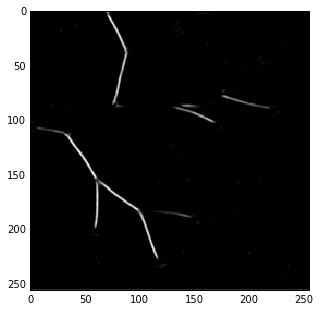

In [40]:

for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img360_list[i], axis=0))

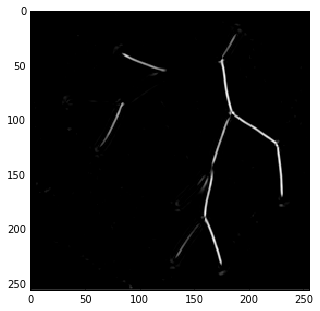

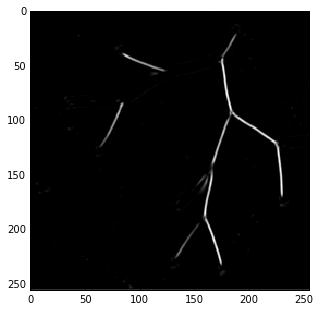

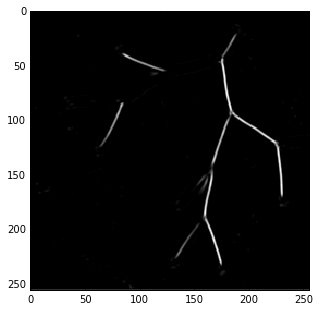

In [42]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img120_list[i], axis=0))